##### Authors: 
Michael Poli & Stefano Massaroli

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

#from torchdiffeq import odeint
from pyPH.model import PHNN
from pyPH.predictors import MLP, genpoints

import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#from matplotlib2tikz import save as tikz_save
import time as time

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

# Duffing Oscillator

$$\begin{bmatrix}\dot{u}\\\dot{v}\end{bmatrix}= \begin{bmatrix}v\\-\alpha u - k v -\beta u^3\end{bmatrix}$$
$$\Leftrightarrow\dot{x}= \Psi(x)$$

In [4]:
a = 1.0
b = 1
c = 1.0
d = 1

In [5]:
# Dissipation rate
k = 0.5

In [6]:
# definition of the ODE
def LV(x,t):
    u = x[0]
    v = x[1]
    dudt = v#a*u - b*u*v #
    dvdt = -a*u - k*v -b*pow(u,3) #-c*v +d*u*v + k*(a-b*v)*v#
    return [dudt,dvdt]

In [7]:
# simulation of the system
N = 200
Tf = 4
Ts = Tf/N
t = np.linspace(0,Tf,N)

# standard form
x0 = [1.5,1]
x = odeint(LV,x0,t)
x1 = odeint(LV,x[-1],t)
t = np.hstack((t,t+t[-1]))
x = np.vstack((x,x1))

In [8]:
print('The sampling time is ',Ts,'s')

The sampling time is  0.02 s


In [9]:
# save original trajectory
orig_traj = x

In [10]:
n = 20
xlim = np.hstack((orig_traj.min(0)[0],orig_traj.max(0)[0]))
ylim = np.hstack((orig_traj.min(0)[1],orig_traj.max(0)[1]))

x1 = np.linspace(xlim[0],xlim[1],n)
x2 = np.linspace(ylim[0],ylim[1],n)
X1,X2 = np.meshgrid(x1,x2)

U = np.zeros((n,n))
V = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        U[i,j], V[i,j] = LV([X1[i,j],X2[i,j]],0)

(-1.9284733365953568, 1.0)

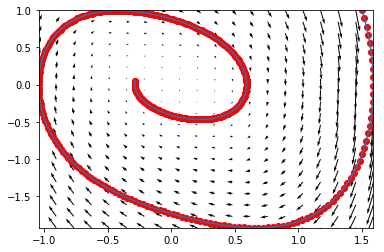

In [11]:
fig, ax = plt.subplots()
q = ax.quiver(X1, X2, U, V,scale = 80)
ax.plot(x[:,0],x[:,1])
ax.scatter(x[:,0],x[:,1], color = 'r')
plt.xlim([xlim[0],xlim[1]])
plt.ylim([ylim[0],ylim[1]])

In [12]:
X1a = X1.reshape(int(n*n),1)
X2a = X2.reshape(int(n*n),1)
Ua = U.reshape(int(n*n),1)
Va = V.reshape(int(n*n),1)

vecField = np.hstack((X1a,np.hstack((X2a,np.hstack((Ua,Va))))))

#saving vecfield
#np.savetxt('VecField.dat', vecField, fmt=['%.3f','%.3f','%.3f','%.3f'],delimiter='\t',header="x\ty\tu\tv",comments = '')

(-1.9284733365953568, 1.0)

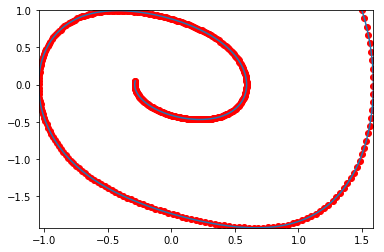

In [13]:
fig, ax = plt.subplots()
ax.plot(x[:,0],x[:,1])
ax.scatter(x[:,0],x[:,1], color = 'r')
plt.xlim([xlim[0],xlim[1]])
plt.ylim([ylim[0],ylim[1]])
#tikz_save('Traj.tex')

## PHNN

Two methods attempted: 1st - approximation of derivative the with $$\hat{y}_i = \frac{(\hat{u}_{i+1} - \hat{u}_{i})}{Ts}$$
2nd - use as labels the vector field produced analytically $$LV(x_{i}, t)$$

In [14]:
x = torch.Tensor(x).to(device)
x[1:]
x0 = x[0].view(1,2)

In [15]:
# with approx
grad = ([(x[i+1] - x[i])/Ts for i in range(len(x)-1)])
grad = torch.Tensor([g.cpu().numpy() for g in grad])
# with real LV
#grad = ([LV(x[i], t) for i in range(len(x)-1)])
#grad = torch.Tensor([g for g in grad])

In [16]:
train = data_utils.TensorDataset(x[:-1], grad)
trainloader = data_utils.DataLoader(train, batch_size=len(orig_traj)-1)

In [76]:
# PHNN definition
obs = PHNN('MLP', [[2, 16, 16, 2], False], [1,1,0], 0.5)

In [77]:
X1t = torch.Tensor(X1).to(device)
X2t = torch.Tensor(X2).to(device)
Up = np.zeros((n,n))
Vp = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        point = torch.Tensor([X1[i,j],X2[i,j]]).to(device)
        Up[i,j], Vp[i,j] = obs.predictor(point.view(1,2))[0][0],obs.predictor(point.view(1,2))[0][1]

Text(0.5, 1.0, 'Pre training approximated vector field')

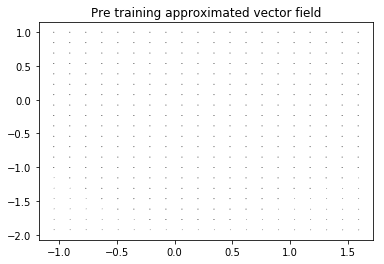

In [78]:
Uo, Vo = Up, Vp

fig, ax = plt.subplots()
q = ax.quiver(X1, X2, Up, Vp, scale = 80)
plt.title("Pre training approximated vector field")

In [79]:
epoch=10000
ode_t=0.01

In [80]:
start_time = time.time()
obs.fit(trainloader, epoch=10000, time_delta=100, iter_accuracy=float('inf'), ode_t=0.01, ode_step=2, criterion='mse')
elapsed_time = time.time() - start_time

odeint iter: 1000 
odeint iter: 2000 
odeint iter: 3000 
odeint iter: 4000 
odeint iter: 5000 
odeint iter: 6000 
odeint iter: 7000 
odeint iter: 8000 
odeint iter: 9000 
odeint iter: 10000 
odeint iter: 11000 
odeint iter: 12000 
odeint iter: 13000 
odeint iter: 14000 
odeint iter: 15000 
odeint iter: 16000 
odeint iter: 17000 
odeint iter: 18000 
odeint iter: 19000 
odeint iter: 20000 
odeint iter: 21000 
odeint iter: 22000 
odeint iter: 23000 
odeint iter: 24000 
odeint iter: 25000 
odeint iter: 26000 
odeint iter: 27000 
odeint iter: 28000 
odeint iter: 29000 
odeint iter: 30000 
odeint iter: 31000 
odeint iter: 32000 
odeint iter: 33000 
odeint iter: 34000 
odeint iter: 35000 
odeint iter: 36000 
odeint iter: 37000 
odeint iter: 38000 
odeint iter: 39000 
odeint iter: 40000 
odeint iter: 41000 
odeint iter: 42000 
odeint iter: 43000 
odeint iter: 44000 
odeint iter: 45000 
odeint iter: 46000 
odeint iter: 47000 
odeint iter: 48000 
odeint iter: 49000 
odeint iter: 50000 
odeint it

In [82]:
print(elapsed_time)

434.4665024280548


In [83]:
T = np.linspace(0,epoch*ode_t,len(J))

Text(0.5, 1.0, 'Loss')

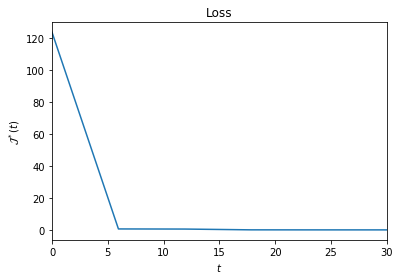

In [94]:
plt.figure()
plt.plot(T[0:-1:10],J[0:-1:10])
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}^*(t)$")
plt.xlim([0,30])
plt.title("Loss")
#plt.savefig('LossVF.eps', format='eps', dpi=300)
#tikz_save('LossVF.tex')

In [95]:
p = len(obs.pWdot)
theta = np.zeros((len(J),p))
omega = np.zeros((len(J),p))
for j in range(p):
    theta[:,j] = ([obs.pW[j][i].tolist() for i in range(len(J))])
    omega[:,j] = ([obs.pWdot[j][i].tolist() for i in range(len(J))])

(0, 30)

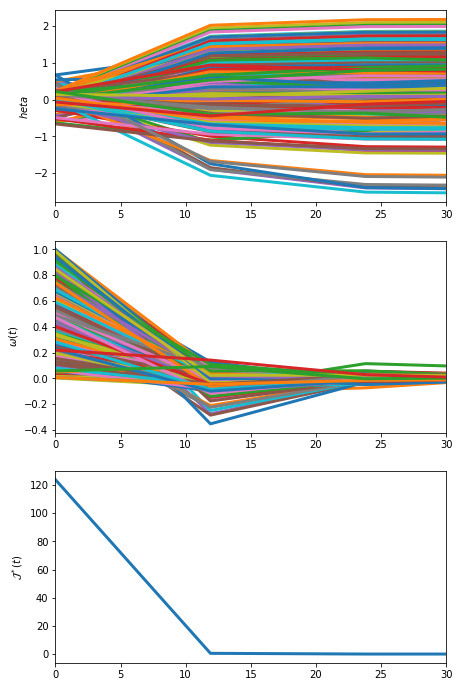

In [99]:
colors = plt.cm.jet(np.linspace(0,1,len(theta)))
plt.figure(figsize=(7,12))
plt.subplot(311);
skip = 20
plt.plot(T[0:-1:skip],theta[0:-1:skip], linewidth = 3, alpha = 1);
plt.ylabel("$\theta$");
plt.xlim([0,30])
plt.subplot(312);
plt.plot(T[0:-1:skip],omega[0:-1:skip], linewidth = 3);
plt.ylabel("$\omega(t)$");
plt.xlim([0,30])
plt.subplot(313);
plt.plot(T[0:-1:skip],J[0:-1:skip], linewidth = 3);
plt.ylabel("$\mathcal{J}^*(t)$")
plt.xlim([0,30])

#plt.savefig('weightsVF.eps', format='eps', dpi=300);
#tikz_save('weightsVF.tex');

### Compute reconstructed vector field & reconstruction error

given the linear system:
\begin{equation}
    \dot{x} = \Psi(x)
\end{equation}
Let the neural network model be
\begin{equation}
    y = f(x,\vartheta)
\end{equation}
After the training, the reconstruction error is computed (in a certain quantized region of the state-space) as
\begin{equation}
    E(x) = \|\Psi(x)-f(x,\vartheta^*)\|_2^2
\end{equation}
where $\vartheta^*$ is the trained vector of parameters

Text(0.5, 1.0, 'Learned vec field vs ground truth')

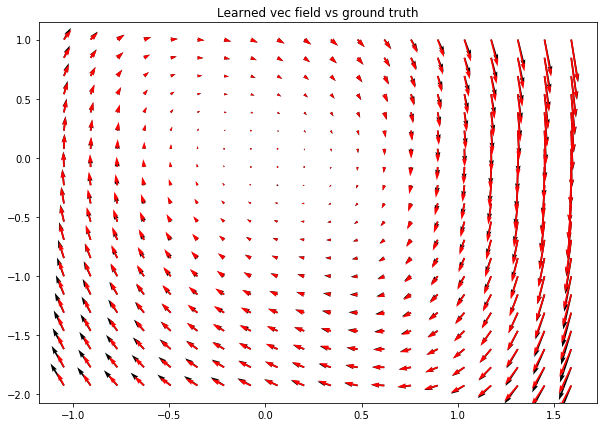

In [100]:
Up = np.zeros((n,n))
Vp = np.zeros((n,n))

for i in range(int(n)):
    for j in range(n):
        point = torch.Tensor([X1[i,j],X2[i,j]]).to(device)
        Up[i,j], Vp[i,j] = obs.predictor(point.view(1,2))[0][0], obs.predictor(point.view(1,2))[0][1]

fig, ax = plt.subplots(figsize=(10,7))
q = ax.quiver(X1, X2, U, V,scale = 80)
q = ax.quiver(X1, X2, Up, Vp, scale = 80,color = 'r')
plt.title("Learned vec field vs ground truth")

In [ ]:
Upa = Up.reshape(int(n*n),1)
Vpa = Vp.reshape(int(n*n),1)

#RecVecField = np.hstack((X1a,np.hstack((X2a,np.hstack((Upa,Vpa))))))
#np.savetxt('RecVecField.dat', RecVecField, fmt=['%.3f','%.3f','%.3f','%.3f'],delimiter='\t',header="x\ty\tu\tv",comments = '')

## Error contour plot

In [88]:
E = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        E[i,j] = np.sqrt(pow(U[i,j]-Up[i,j],2)+pow(V[i,j]-Vp[i,j],2))#/np.sqrt(pow(U[i,j],2)+pow(V[i,j],2))

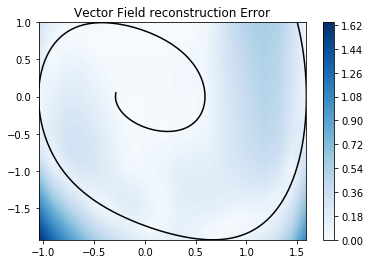

In [101]:
#### Plot contour map of the vector field's reconstruction error
plt.contourf(X1, X2, E,100,cmap='Blues')
plt.plot(orig_traj[:,0],orig_traj[:,1], color='black')
plt.colorbar()
plt.title("Vector Field reconstruction Error")

Ea = E.reshape(int(n*n),1)

error = np.hstack((X1a,np.hstack((X2a,Ea))))
#np.savetxt('Error.dat', error, fmt=['%.3f','%.3f','%.3f'])

## Reconstructed trajectory

We want to compare the reference trajectory $x_{r}(t)$ obtained by integrating the ODE $\dot{x}=\Psi(x)$ with $x_r(0) = x_0$ with a trajectory $\hat{x}(t)$ obtained by integrating $\dot{x}= f(x,\theta^*)$ (the NN model) with the same initial condition.

We can then evaluate how the reconstructed trajectory remains close to $x_r(t)$

In [102]:
def LV_Learned(xi0, t):
    return obs.predictor(torch.Tensor(xi0).view(1,2).to(device)).flatten().detach().cpu()

In [103]:
func = LV_Learned
t = np.linspace(0,2*Tf,2*N)
x0 = [1.5, 1]
sol = odeint(func, x0, t)

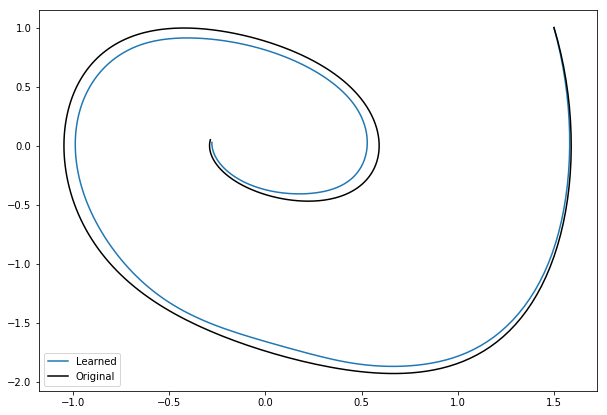

In [104]:
plt.figure(figsize=(10,7))
plt.plot([s[0] for s in sol], [s[1] for s in sol])
plt.plot(orig_traj[:,0],orig_traj[:,1], color='black')
plt.legend(['Learned','Original'])

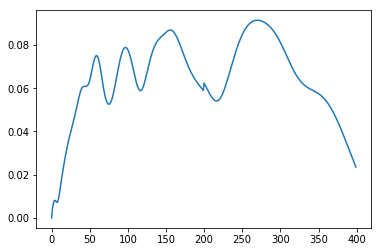

In [105]:
e = ([np.linalg.norm(sol[i]-orig_traj[i]) for i in range(len(orig_traj))])

plt.figure()
plt.plot(e)